
## Predictive modeling of customer bookings

This Jupyter notebook includes some code to get you started with this predictive modeling task. We will use various packages for data manipulation, feature engineering and machine learning.

### Exploratory data analysis

First, we must explore the data in order to better understand what we have and the statistical properties of the dataset.

In [4]:
import pandas as pd
from matplotlib import pyplot as plt
import seaborn as sns


In [5]:
import numpy as np
from matplotlib.colors import ListedColormap
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.ensemble import HistGradientBoostingClassifier
from category_encoders import TargetEncoder
from xgboost import XGBClassifier

In [6]:
df = pd.read_csv("customer_booking.csv", encoding="ISO-8859-1")
df.head()

,num_passengers,sales_channel,trip_type,purchase_lead,length_of_stay,flight_hour,flight_day,route,booking_origin,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
0,2,Internet,RoundTrip,262,19,7,Sat,AKLDEL,New Zealand,1,0,0,5.52,0
1,1,Internet,RoundTrip,112,20,3,Sat,AKLDEL,New Zealand,0,0,0,5.52,0
2,2,Internet,RoundTrip,243,22,17,Wed,AKLDEL,India,1,1,0,5.52,0
3,1,Internet,RoundTrip,96,31,4,Sat,AKLDEL,New Zealand,0,0,1,5.52,0
4,2,Internet,RoundTrip,68,22,15,Wed,AKLDEL,India,1,0,1,5.52,0


The `.head()` method allows us to view the first 5 rows in the dataset, this is useful for visual inspection of our columns

In [7]:
df['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50000 entries, 0 to 49999
Data columns (total 14 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   num_passengers         50000 non-null  int64  
 1   sales_channel          50000 non-null  object 
 2   trip_type              50000 non-null  object 
 3   purchase_lead          50000 non-null  int64  
 4   length_of_stay         50000 non-null  int64  
 5   flight_hour            50000 non-null  int64  
 6   flight_day             50000 non-null  object 
 7   route                  50000 non-null  object 
 8   booking_origin         50000 non-null  object 
 9   wants_extra_baggage    50000 non-null  int64  
 10  wants_preferred_seat   50000 non-null  int64  
 11  wants_in_flight_meals  50000 non-null  int64  
 12  flight_duration        50000 non-null  float64
 13  booking_complete       50000 non-null  int64  
dtypes: float64(1), int64(8), object(5)
memory usage: 5.3+ 

The `.info()` method gives us a data description, telling us the names of the columns, their data types and how many null values we have. Fortunately, we have no null values. It looks like some of these columns should be converted into different data types, e.g. flight_day.

To provide more context, below is a more detailed data description, explaining exactly what each column means:

- `num_passengers` = number of passengers travelling
- `sales_channel` = sales channel booking was made on
- `trip_type` = trip Type (Round Trip, One Way, Circle Trip)
- `purchase_lead` = number of days between travel date and booking date
- `length_of_stay` = number of days spent at destination
- `flight_hour` = hour of flight departure
- `flight_day` = day of week of flight departure
- `route` = origin -> destination flight route
- `booking_origin` = country from where booking was made
- `wants_extra_baggage` = if the customer wanted extra baggage in the booking
- `wants_preferred_seat` = if the customer wanted a preferred seat in the booking
- `wants_in_flight_meals` = if the customer wanted in-flight meals in the booking
- `flight_duration` = total duration of flight (in hours)
- `booking_complete` = flag indicating if the customer completed the booking

Before we compute any statistics on the data, lets do any necessary data conversion

In [9]:
df['sales_channel'] = df['sales_channel'].map({"Internet":1, "Mobile":0})

In [10]:
df.describe()

,num_passengers,sales_channel,purchase_lead,length_of_stay,flight_hour,wants_extra_baggage,wants_preferred_seat,wants_in_flight_meals,flight_duration,booking_complete
count,50000.000000,50000.000000,50000.000000,50000.00000,50000.00000,50000.000000,50000.000000,50000.000000,50000.000000,50000.000000
mean,1.591240,0.887640,84.940480,23.04456,9.06634,0.668780,0.296960,0.427140,7.277561,0.149560
std,1.020165,0.315812,90.451378,33.88767,5.41266,0.470657,0.456923,0.494668,1.496863,0.356643
min,1.000000,0.000000,0.000000,0.00000,0.00000,0.000000,0.000000,0.000000,4.670000,0.000000
25%,1.000000,1.000000,21.000000,5.00000,5.00000,0.000000,0.000000,0.000000,5.620000,0.000000
50%,1.000000,1.000000,51.000000,17.00000,9.00000,1.000000,0.000000,0.000000,7.570000,0.000000
75%,2.000000,1.000000,115.000000,28.00000,13.00000,1.000000,1.000000,1.000000,8.830000,0.000000
max,9.000000,1.000000,867.000000,778.00000,23.00000,1.000000,1.000000,1.000000,9.500000,1.000000


The `.describe()` method gives us a summary of descriptive statistics over the entire dataset (only works for numeric columns). This gives us a quick overview of a few things such as the mean, min, max and overall distribution of each column.

# Visualizing the data

/var/folders/t0/prcwsryx44jd6j6zsp98vwch0000gn/T/ipykernel_36310/58359773.py:1: FutureWarning: The default value of numeric_only in DataFrame.corr is deprecated. In a future version, it will default to False. Select only valid columns or specify the value of numeric_only to silence this warning.
  sns.heatmap(df.corr())


<Axes: >

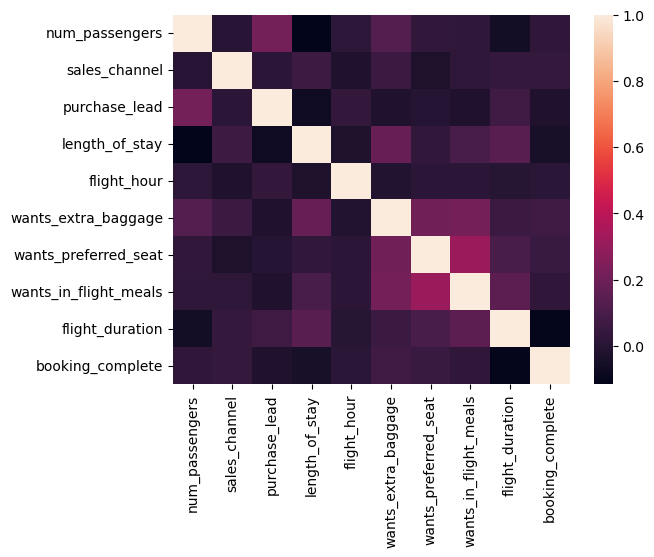

In [11]:
sns.heatmap(df.corr())

In [12]:
df['booking_complete'].value_counts()

0    42522
1     7478
Name: booking_complete, dtype: int64

In [13]:
column_list = ['num_passengers',	'sales_channel',	'trip_type',	'purchase_lead',	'length_of_stay',	'flight_hour',	'flight_day',	'wants_extra_baggage',	'wants_preferred_seat',	'wants_in_flight_meals',	'flight_duration']

Text(0.5, 1.0, 'Percentage of people booking the flight against number of passengers')

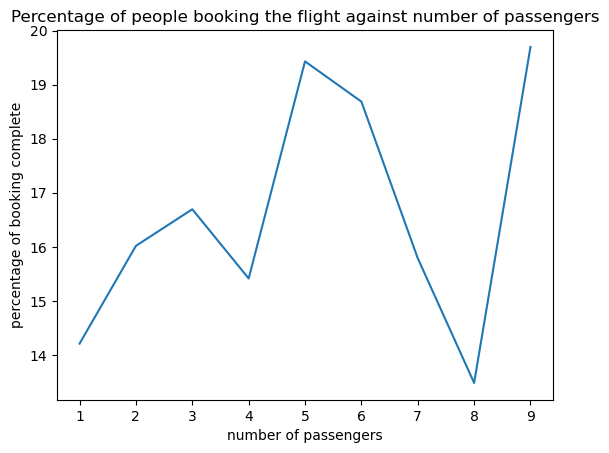

In [14]:
num_passengers = df.groupby(by=['num_passengers','booking_complete']).size().unstack(fill_value=0)
num_passengers['ratio'] = num_passengers[1] * 100/ (num_passengers[0]+num_passengers[1])
sns.lineplot(num_passengers,x=num_passengers.index.to_list(),y='ratio')
plt.xlabel('number of passengers')
plt.ylabel('percentage of booking complete')
plt.title('Percentage of people booking the flight against number of passengers')

It can be seen that as the number of passengers increase the percentage of people booking the flight also increases. But decreases again after 5. 9 passengers is an outlier with very low samples and hence shows high percentage.

Text(0.5, 1.0, 'Percentage of booking complete in each day of the week')

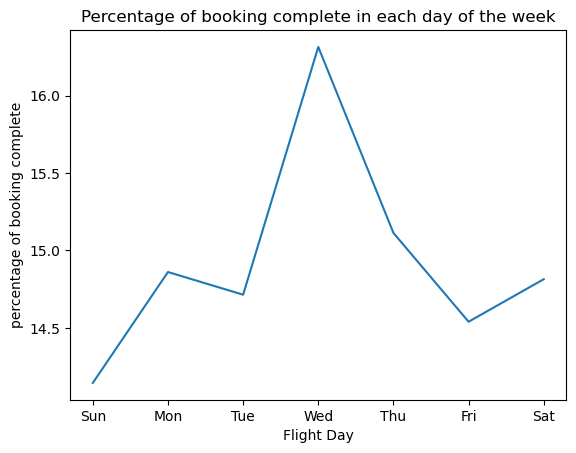

In [15]:
flight_day = df.groupby(by=['flight_day','booking_complete']).size().unstack()
flight_day['ratio'] = flight_day[1]*100/(flight_day[0]+flight_day[1])
days = ['Sun','Mon','Tue','Wed','Thu','Fri','Sat']
day_dict = {}
for day in days:
    day_dict[day] = flight_day.loc[day]['ratio']
sns.lineplot(day_dict)
plt.xlabel('Flight Day')
plt.ylabel('percentage of booking complete')
plt.title('Percentage of booking complete in each day of the week')

This shows that most people like to travel on the wednesday when flights are the cheapest.

([<matplotlib.axis.XTick at 0x2878c1540>,
 [Text(0, 0, '0'),
  Text(1, 0, '1'),
  Text(2, 0, '2'),
  Text(3, 0, '3'),
  Text(4, 0, '4'),
  Text(5, 0, '5'),
  Text(6, 0, '6'),
  Text(7, 0, '7'),
  Text(8, 0, '8'),
  Text(9, 0, '9'),
  Text(10, 0, '10'),
  Text(11, 0, '11'),
  Text(12, 0, '12'),
  Text(13, 0, '13'),
  Text(14, 0, '14'),
  Text(15, 0, '15'),
  Text(16, 0, '16'),
  Text(17, 0, '17'),
  Text(18, 0, '18'),
  Text(19, 0, '19'),
  Text(20, 0, '20'),
  Text(21, 0, '21'),
  Text(22, 0, '22'),
  Text(23, 0, '23')])

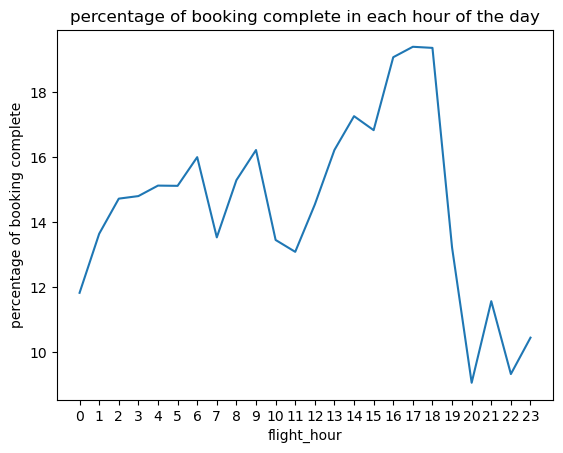

In [16]:
flight_hour = df.groupby(by=['flight_hour','booking_complete']).size().unstack()
flight_hour['ratio'] = flight_hour[1]*100/(flight_hour[0]+flight_hour[1])
sns.lineplot(flight_hour,x=flight_hour.index.to_list(), y='ratio')
plt.xlabel('flight_hour')
plt.ylabel('percentage of booking complete')
plt.title('percentage of booking complete in each hour of the day')
plt.xticks(range(0,24))

This shows that the person is more likely to complete the booking if the flight departs 15 hrs to 18 hrs

# Training the XGboost Model

In [17]:
X = df.drop(columns=['booking_complete'])
y = df['booking_complete']

In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y,stratify=y, random_state=0)

To encode the data target encoders are used which calculates the probability of a categorical value against the target value.

In [19]:
enc = TargetEncoder(verbose=0,cols=['trip_type','flight_day', 'route',
       'booking_origin'])
clf = XGBClassifier(random_state=0)

estimators = [
    ('encoder',enc),
    ('clf', clf)
]

For hyperparameter tuning BayesSearchCV from Scikit optimizers has been chosen.

In [20]:
from skopt import BayesSearchCV
from skopt.space import Integer, Real

In [21]:
pipe = Pipeline(steps=estimators)
pipe

Pipeline(steps=[('encoder',
                 TargetEncoder(cols=['trip_type', 'flight_day', 'route',
                                     'booking_origin'])),
                ('clf',
                 XGBClassifier(base_score=None, booster=None, callbacks=None,
                               colsample_bylevel=None, colsample_bynode=None,
                               colsample_bytree=None, device=None,
                               early_stopping_rounds=None,
                               enable_categorical=False, eval_metric=None,
                               feature_types=None, gamma=None, grow_policy=None,
                               importance_type=None,
                               interaction_constraints=None, learning_rate=None,
                               max_bin=None, max_cat_threshold=None,
                               max_cat_to_onehot=None, max_delta_step=None,
                               max_depth=None, max_leaves=None,
                               min_child_weight=None, missing=nan,
                               monotone_constraints=None, multi_strategy=None,
                               n_estimators=None, n_jobs=None,
                               num_parallel_tree=None, random_state=0, ...))])

In [22]:
search_space = {
    'clf__max_depth': Integer(2,8),
    'clf__learning_rate': Real(0.001,1.0, prior='log-uniform'),
    'clf__colsample_bytree': Real(0.5,1.0),
    'clf__colsample_bylevel': Real(0.5,1.0),
    'clf__colsample_bynode': Real(0.5,1.0),
    'clf__reg_alpha': Real(0.0,10.0),
    'clf__reg_lambda': Real(0.0,10.0),
    'clf__gamma': Real(0.0,10.0)
}

In [23]:
opt = BayesSearchCV(pipe, search_space, cv=10, n_iter=50, scoring='f1_weighted', random_state=0)

In [24]:
opt.fit(X_train,y_train)

BayesSearchCV(cv=10,
              estimator=Pipeline(steps=[('encoder',
                                         TargetEncoder(cols=['trip_type',
                                                             'flight_day',
                                                             'route',
                                                             'booking_origin'])),
                                        ('clf',
                                         XGBClassifier(base_score=None,
                                                       booster=None,
                                                       callbacks=None,
                                                       colsample_bylevel=None,
                                                       colsample_bynode=None,
                                                       colsample_bytree=None,
                                                       device=None,
                                                       early_stopping_rounds=None,
                                                       enable_categorical=False,
                                                       eval_metric=None,
                                                       feature...
                             'clf__gamma': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__learning_rate': Real(low=0.001, high=1.0, prior='log-uniform', transform='normalize'),
                             'clf__max_depth': Integer(low=2, high=8, prior='uniform', transform='normalize'),
                             'clf__reg_alpha': Real(low=0.0, high=10.0, prior='uniform', transform='normalize'),
                             'clf__reg_lambda': Real(low=0.0, high=10.0, prior='uniform', transform='normalize')})

In [25]:
y_pred = opt.predict(X_test)

In [26]:
from sklearn.metrics import classification_report

In [27]:
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.87      0.97      0.91     10631
           1       0.47      0.17      0.25      1869

    accuracy                           0.85     12500
   macro avg       0.67      0.57      0.58     12500
weighted avg       0.81      0.85      0.82     12500



It can be seen that the model predicts the target with 85% accuracy. But still the f1 score for predicting the customer booking correctly is only 26%. But still this model was trained to extract the importances of the features.

Extract the best model

In [28]:
best_model = opt.best_estimator_.steps[1][1]

# Feature Importances

In [29]:
from xgboost import plot_importance

<Axes: title={'center': 'Feature importance'}, xlabel='F score', ylabel='Features'>

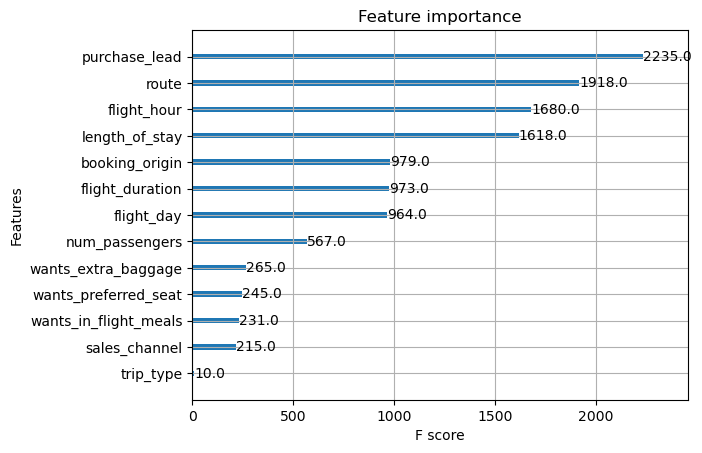

In [30]:
plot_importance(best_model)

It can be seen that the purchase lead is by far the most important feature in the whole dataset followed by route which is a high dimensional feature.

# Explore the Purchase Lead Feature

<Axes: xlabel='purchase_lead', ylabel='Count'>

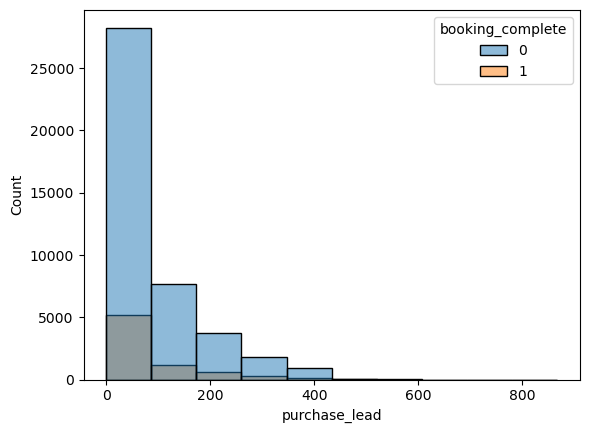

In [31]:
sns.histplot(df,x='purchase_lead', bins=10, hue='booking_complete')

In [32]:
bins = [0,15,30,45,60,75,90,120,150,180,250,350,450,900]
labels = ['0-15','15-30','30-45','45-60','60-75','75-90','90-120','120-150','150-180','180-250','250-350','350-450','450-900']
df['purchase_lead_bins'] = pd.cut(df['purchase_lead'],bins=bins,labels=labels)

In [33]:
histogram = df.groupby(by=['purchase_lead_bins','booking_complete']).size().unstack(fill_value=0)
histogram['ratio'] = histogram[1]*100 / (histogram[0] + histogram[1])
histogram

booking_complete,0,1,ratio
purchase_lead_bins,,,
0-15,7424,1610,17.821563
15-30,6568,1167,15.087266
30-45,4974,868,14.857925
45-60,4078,748,15.499378
60-75,3038,482,13.693182
75-90,2446,381,13.477184
90-120,3448,556,13.886114
120-150,2220,337,13.179507
150-180,1805,261,12.633107


Text(0.5, 1.0, 'Ratio of Booking Complete against Purchase Lead')

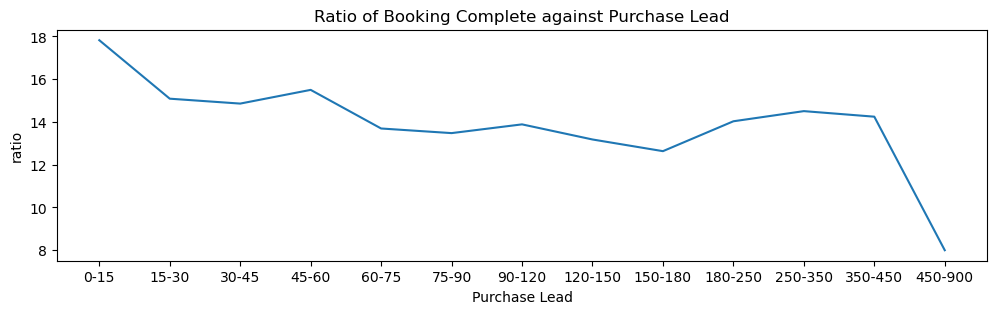

In [34]:
fig= plt.figure(figsize=(12,3))
sns.lineplot(histogram, x=histogram.index.to_list(), y='ratio')
plt.xlabel('Purchase Lead')
plt.title('Ratio of Booking Complete against Purchase Lead')

This graph shows the how the purchase lead affects the percentage of bookings complete. The percentage is the highest when the lead is the lowest.